In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.layers import Dense
from keras.models import Sequential
from keras import optimizers

In [2]:
# Styles

my_style = {
    'figure.facecolor': '#111111',
    'axes.facecolor': '#111111',
    'axes.labelcolor': '#bbbbbb',
    'axes.titlecolor': '#bbbbbb',
    'xtick.color': '#bbbbbb',
    'ytick.color': '#bbbbbb',
    'legend.facecolor': '#111111',
    'legend.edgecolor': '#bbbbbb',
    'text.color': '#bbbbbb',
    'axes.edgecolor': '#bbbbbb',
    'font.size': 10
}

plt.style.use(my_style)

#### Labels & others

In [3]:
# labels
dict_things = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# input layer size
layer_size_0 = 28*28  # 784

# check GPU
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Reset Keras

In [4]:
# Reset Keras Session | clear memory GPU

from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    # garbage collector
    gc.collect()

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = '0'
    set_session(tf.compat.v1.Session(config=config))

#### Split dataset

In [5]:
(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()

print(X_train.shape, X_test.shape)
print(y_train_labels.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,)


#### Random thing

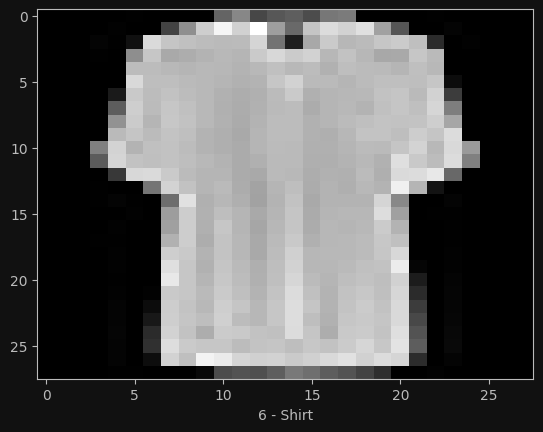

In [6]:
index = np.random.randint(0, X_train.shape[0])
index_thing = y_train_labels[index]

plt.imshow(X_train[index], cmap="gray", aspect="auto")
plt.xlabel(f'{index_thing} - {dict_things[index_thing]}')
plt.show()

#### Normalization

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train.min(), X_train.max()

X_train = X_train.reshape((-1, 28 * 28))
X_test = X_test.reshape((-1, 28*28))
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

#### One hot

In [8]:
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

#### Hide layer size

#### Optimizers comparison

In [195]:
# Size hide layer => 784 | x | 10
batch_size = 100
evaluation = { 'train': [], 'test': [] }
layers_size = [i for i in range(10)] + [i**2 for i in range(4, 25) if i % 2 == 0]

for layer_size in layers_size:
    # clear memory GPU
    reset_keras()

    # skeleton
    model = Sequential([
        Dense(layer_size, input_shape=(layer_size_0,), activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics='accuracy'
    )

    # learning
    model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=10,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    # loss, metrics
    train_evals = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
    test_evals = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)

    evaluation['train'].append(train_evals)
    evaluation['test'].append(test_evals)

    if layer_size % 6 == 0:
        print(f'Size of hide layer: {layer_size}\n'
              f'Train Loss:\t{train_evals[0]:.3f}\tTrain Accuracy:\t{train_evals[1]:.3f}\n'
              f'Test Loss:\t{test_evals[0]:.3f}\tTest Accuracy:\t{test_evals[1]:.3f}\n'
        )

Size of hide layer: 0
Train Loss:	2.303	Train Accuracy:	0.100
Test Loss:	2.303	Test Accuracy:	0.100

Size of hide layer: 6
Train Loss:	0.719	Train Accuracy:	0.722
Test Loss:	0.755	Test Accuracy:	0.710

Size of hide layer: 36
Train Loss:	0.310	Train Accuracy:	0.889
Test Loss:	0.381	Test Accuracy:	0.868

Size of hide layer: 144
Train Loss:	0.233	Train Accuracy:	0.915
Test Loss:	0.335	Test Accuracy:	0.882

Size of hide layer: 324
Train Loss:	0.215	Train Accuracy:	0.921
Test Loss:	0.325	Test Accuracy:	0.882

Size of hide layer: 576
Train Loss:	0.219	Train Accuracy:	0.919
Test Loss:	0.329	Test Accuracy:	0.885



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 36, 64, 100, 144, 196, 256, 324, 400, 484, 576]


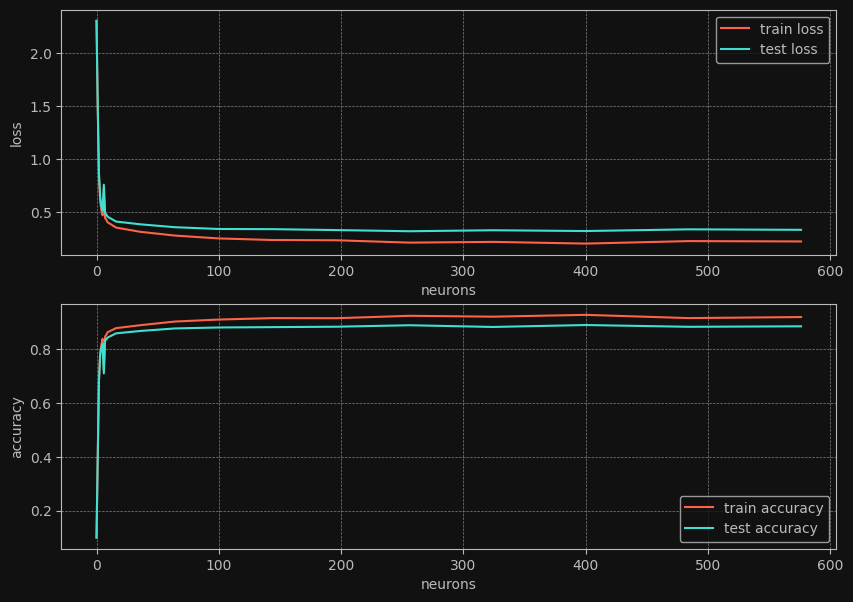

In [196]:
print(layers_size)

plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
plt.plot(layers_size, np.array(evaluation['train'])[:, 0], c='tomato', label="train loss")
plt.plot(layers_size, np.array(evaluation['test'])[:, 0], c='turquoise', label="test loss")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("neurons")
plt.ylabel("loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(layers_size, np.array(evaluation['train'])[:, 1], c='tomato', label="train accuracy")
plt.plot(layers_size, np.array(evaluation['test'])[:, 1], c='turquoise', label="test accuracy")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("neurons")
plt.ylabel("accuracy")
plt.legend()

plt.show()

По графику становится очевидно, что бОльшее количество нейронов в слое имеет значение, но стоит учитывать, что сильное увеличение не даст большого прироста точности. Так же вычисление результатов становится более ресурсозатратным. Так же можно заметить, что скрытый слой с 400 нейронами дает наилучший результат. После начинается небольшой спад точности. Вероятнее всего каждая новая модель с бОльшим количеством нейронов подвергается переобучению.

#### Number of hidden layers \<identical size\>

In [197]:
# 600 neurons in all hidden layers
evaluation = { 'train': [], 'test': [] }
neurons_all = 400

layers_neurons = []

for i in range(0, 10):
    # clear memory GPU
    reset_keras()

    # hidden_layers => exclude first | need add +1 in print result
    # neurons => same value to every hidden layer
    hidden_layers, neurons = i, round(neurons_all / (i+1))

    layers_neurons.append((hidden_layers+1, neurons))

    # Skeleton
    model = Sequential([
        Dense(neurons, input_shape=(layer_size_0,), activation='relu'),
        *np.repeat(Dense(neurons, activation='relu'), hidden_layers),
        Dense(10, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics='accuracy'
    )

    # learning
    model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=10,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    # loss, metrics
    train_evals = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
    test_evals = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)

    evaluation['train'].append(train_evals)
    evaluation['test'].append(test_evals)

    print(f'Number hidden layers: {hidden_layers + 1}\n'
          f'Neurons in one layer: {neurons}\n'
          f'Train Loss:\t{train_evals[0]:.3f}\tTrain Accuracy:\t{train_evals[1]:.3f}\n'
          f'Test Loss:\t{test_evals[0]:.3f}\tTest Accuracy:\t{test_evals[1]:.3f}\n'
    )

Number hidden layers: 1
Neurons in one layer: 400
Train Loss:	0.224	Train Accuracy:	0.914
Test Loss:	0.337	Test Accuracy:	0.879

Number hidden layers: 2
Neurons in one layer: 200
Train Loss:	0.211	Train Accuracy:	0.919
Test Loss:	0.320	Test Accuracy:	0.889

Number hidden layers: 3
Neurons in one layer: 133
Train Loss:	0.232	Train Accuracy:	0.912
Test Loss:	0.343	Test Accuracy:	0.880

Number hidden layers: 4
Neurons in one layer: 100
Train Loss:	0.243	Train Accuracy:	0.909
Test Loss:	0.338	Test Accuracy:	0.880

Number hidden layers: 5
Neurons in one layer: 80
Train Loss:	0.244	Train Accuracy:	0.909
Test Loss:	0.333	Test Accuracy:	0.878

Number hidden layers: 6
Neurons in one layer: 67
Train Loss:	0.288	Train Accuracy:	0.894
Test Loss:	0.383	Test Accuracy:	0.868

Number hidden layers: 7
Neurons in one layer: 57
Train Loss:	0.259	Train Accuracy:	0.905
Test Loss:	0.348	Test Accuracy:	0.878

Number hidden layers: 8
Neurons in one layer: 50
Train Loss:	0.269	Train Accuracy:	0.901
Test Loss:	

[(1, 400), (2, 200), (3, 133), (4, 100), (5, 80), (6, 67), (7, 57), (8, 50), (9, 44), (10, 40)]


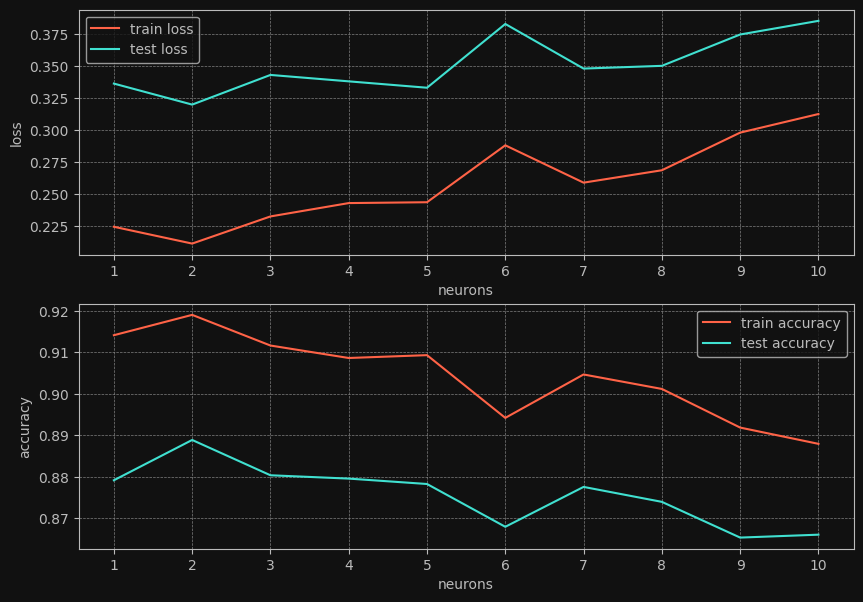

In [198]:
print(layers_neurons)

layers = [i for i in range(1, 11)]

plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
plt.plot(layers, np.array(evaluation['train'])[:, 0], c='tomato', label="train loss")
plt.plot(layers, np.array(evaluation['test'])[:, 0], c='turquoise', label="test loss")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("neurons")
plt.ylabel("loss")
plt.xticks(range(1, 11, 1))
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(layers, np.array(evaluation['train'])[:, 1], c='tomato', label="train accuracy")
plt.plot(layers, np.array(evaluation['test'])[:, 1], c='turquoise', label="test accuracy")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("neurons")
plt.ylabel("accuracy")
plt.xticks(range(1, 11, 1))
plt.legend()

plt.show()

#### Result

Best model (iter 1):
Number hidden layers: 2
Neurons in one layer: 200
Train Loss:	0.211	Train Accuracy:	0.919
Test Loss:	0.320	Test Accuracy:	0.889

#### Number of hidden layers \<various size\>

In [199]:
# 600 neurons in all hidden layers
evaluation = { 'train': [], 'test': [] }
neurons_all = 400

layers_neurons = []

for i in range(0, 10):
    # clear memory GPU
    reset_keras()

    # hidden_layers => exclude first | need add +1 in print result
    # neurons => same value to every hidden layer
    hidden_layers, first_layer_neurons = i, neurons_all // (i+1)
    layers_neurons = []

    for j in range(1, hidden_layers+1):
        neurons_one_layer = int(first_layer_neurons * (hidden_layers - j + 1) / hidden_layers)
        layers_neurons.append(neurons_one_layer)

    layers_neurons.insert(0, first_layer_neurons)

    sum_neurons = sum(layers_neurons)
    diff = neurons_all - sum_neurons

    # sum == 600
    layers_neurons[0] += diff

    # Skeleton
    model = Sequential([
        Dense(layers_neurons[0], input_shape=(layer_size_0,), activation='relu'),
        *[Dense(m, activation='relu') for m in layers_neurons[1:]],
        Dense(10, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics='accuracy'
    )

    # learning
    model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=10,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    # loss, metrics
    train_evals = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
    test_evals = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)

    evaluation['train'].append(train_evals)
    evaluation['test'].append(test_evals)

    print(f'Number hidden layers: {hidden_layers + 1}\n'
          f'Neurons in all layers: {layers_neurons}\n'
          f'Train Loss:\t{train_evals[0]:.3f}\tTrain Accuracy:\t{train_evals[1]:.3f}\n'
          f'Test Loss:\t{test_evals[0]:.3f}\tTest Accuracy:\t{test_evals[1]:.3f}\n'
    )

Number hidden layers: 1
Neurons in all layers: [400]
Train Loss:	0.219	Train Accuracy:	0.918
Test Loss:	0.332	Test Accuracy:	0.885

Number hidden layers: 2
Neurons in all layers: [200, 200]
Train Loss:	0.217	Train Accuracy:	0.918
Test Loss:	0.339	Test Accuracy:	0.887

Number hidden layers: 3
Neurons in all layers: [201, 133, 66]
Train Loss:	0.218	Train Accuracy:	0.918
Test Loss:	0.328	Test Accuracy:	0.885

Number hidden layers: 4
Neurons in all layers: [201, 100, 66, 33]
Train Loss:	0.215	Train Accuracy:	0.919
Test Loss:	0.329	Test Accuracy:	0.887

Number hidden layers: 5
Neurons in all layers: [200, 80, 60, 40, 20]
Train Loss:	0.230	Train Accuracy:	0.913
Test Loss:	0.341	Test Accuracy:	0.881

Number hidden layers: 6
Neurons in all layers: [204, 66, 52, 39, 26, 13]
Train Loss:	0.221	Train Accuracy:	0.919
Test Loss:	0.328	Test Accuracy:	0.887

Number hidden layers: 7
Neurons in all layers: [202, 57, 47, 38, 28, 19, 9]
Train Loss:	0.246	Train Accuracy:	0.908
Test Loss:	0.344	Test Accurac

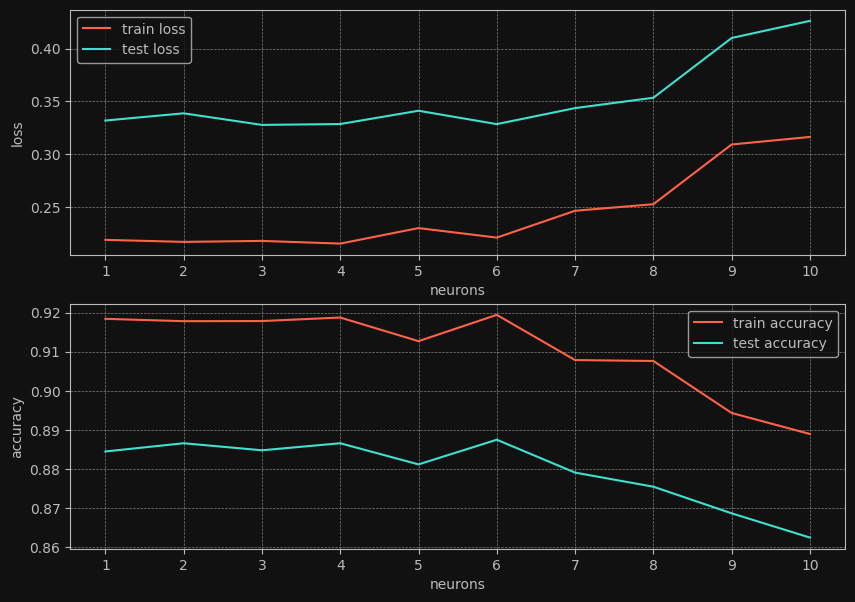

In [200]:
layers = [i for i in range(1, 11)]

plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
plt.plot(layers, np.array(evaluation['train'])[:, 0], c='tomato', label="train loss")
plt.plot(layers, np.array(evaluation['test'])[:, 0], c='turquoise', label="test loss")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("neurons")
plt.ylabel("loss")
plt.xticks(range(1, 11, 1))
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(layers, np.array(evaluation['train'])[:, 1], c='tomato', label="train accuracy")
plt.plot(layers, np.array(evaluation['test'])[:, 1], c='turquoise', label="test accuracy")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("neurons")
plt.ylabel("accuracy")
plt.xticks(range(1, 11, 1))
plt.legend()

plt.show()

#### Result
Best model:
Number hidden layers: 6
Neurons in all layers: [204, 66, 52, 39, 26, 13]
Train Loss:	0.221	Train Accuracy:	0.919
Test Loss:	0.328	Test Accuracy:	0.887

Лучшая модель с равномерным распределением
Number hidden layers: 2
Neurons in one layer: 200
Train Loss: 0.211 Train Accuracy: 0.919
Test Loss: 0.320 Test Accuracy: 0.889

Если сравнивать равномерное распределение нейронов по слоям и распределение с уменьшением нейронов в каждом слое, то результат весьма не однозначный. Лучшие модели показывают почти одинаковые итоги. Более того во втором цикле есть точно такая же модель как и в первом, но она показала менее качественный результат.

Учитывая выше изложенное, выберем ту модель, которая легче поддается обучению и более предсказуема.
Модель с двумя слоями будет более предпочтительна, так как модель с 6 слоями может привести к непредсказуемым результатам, если мы захоти ее улучшить, подкорректировав параметры.

#### Batch size

In [225]:
evaluation = { 'train': [], 'test': [] }
batches = [45, 50, 55, 70, 90, 100, 200, 250, 500, 1000]

for batch in batches:

    # clear memory GPU
    reset_keras()

    model = Sequential([
        Dense(200, input_shape=(layer_size_0,), activation='relu'),
        Dense(200, activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(
        X_train, y_train,
        batch_size=batch,
        epochs=20, verbose=0,
        validation_data = (X_test, y_test)
    )

        # loss, metrics
    train_evals = model.evaluate(X_train, y_train, verbose=0, batch_size=batch)
    test_evals = model.evaluate(X_test, y_test, verbose=0, batch_size=batch)

    evaluation['train'].append(train_evals)
    evaluation['test'].append(test_evals)

    print(f'batch size:\t{batch}\n'
          f'Train Loss:\t{train_evals[0]:.3f}\tTrain Accuracy:\t{train_evals[1]:.3f}\n'
          f'Test Loss:\t{test_evals[0]:.3f}\tTest Accuracy:\t{test_evals[1]:.3f}\n'
    )

batch size:	45
Train Loss:	0.153	Train Accuracy:	0.940
Test Loss:	0.384	Test Accuracy:	0.886

batch size:	50
Train Loss:	0.148	Train Accuracy:	0.944
Test Loss:	0.373	Test Accuracy:	0.890

batch size:	55
Train Loss:	0.147	Train Accuracy:	0.945
Test Loss:	0.349	Test Accuracy:	0.895

batch size:	70
Train Loss:	0.151	Train Accuracy:	0.942
Test Loss:	0.369	Test Accuracy:	0.890

batch size:	90
Train Loss:	0.142	Train Accuracy:	0.946
Test Loss:	0.366	Test Accuracy:	0.889

batch size:	100
Train Loss:	0.155	Train Accuracy:	0.939
Test Loss:	0.357	Test Accuracy:	0.887

batch size:	200
Train Loss:	0.151	Train Accuracy:	0.943
Test Loss:	0.341	Test Accuracy:	0.894

batch size:	250
Train Loss:	0.151	Train Accuracy:	0.945
Test Loss:	0.331	Test Accuracy:	0.899

batch size:	500
Train Loss:	0.173	Train Accuracy:	0.937
Test Loss:	0.321	Test Accuracy:	0.890

batch size:	1000
Train Loss:	0.202	Train Accuracy:	0.926
Test Loss:	0.319	Test Accuracy:	0.889



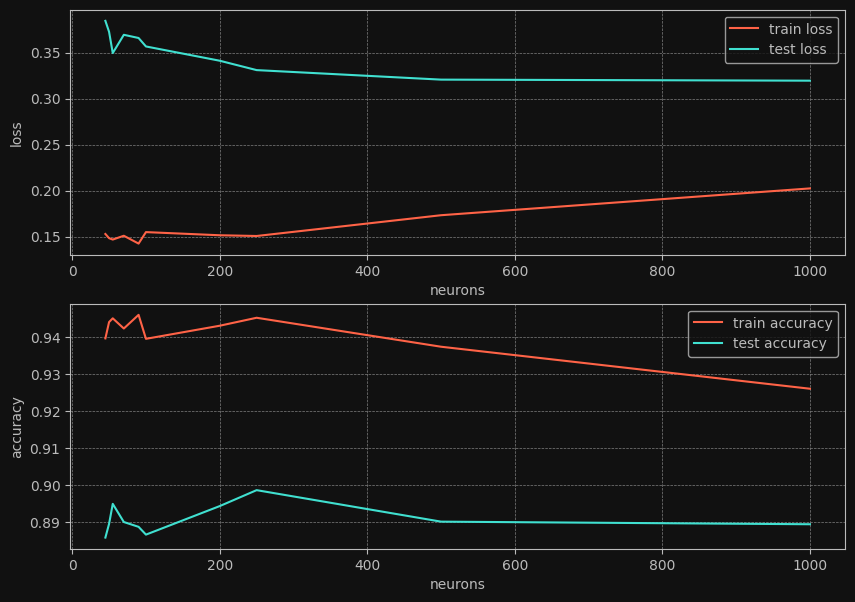

In [226]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
plt.plot(batches, np.array(evaluation['train'])[:, 0], c='tomato', label="train loss")
plt.plot(batches, np.array(evaluation['test'])[:, 0], c='turquoise', label="test loss")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("neurons")
plt.ylabel("loss")
# plt.xticks(range(1, 11, 1))
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(batches, np.array(evaluation['train'])[:, 1], c='tomato', label="train accuracy")
plt.plot(batches, np.array(evaluation['test'])[:, 1], c='turquoise', label="test accuracy")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("neurons")
plt.ylabel("accuracy")
# plt.xticks(range(1, 11, 1))
plt.legend()

plt.show()

#### Result
Best model:
batch size:	250
Train Loss:	0.151	Train Accuracy:	0.945
Test Loss:	0.331	Test Accuracy:	0.899

Показатели качества test набора являются более важными. Test Accuracy имеет максимальное значение. Test Loss в среднем диапазоне.

#### Epochs
Попробуем изменить количество эпох.

In [229]:
evaluation = { 'train': [], 'test': [] }
batch_size=250

for epoch in range(15, 25):
    # clear memory GPU
    reset_keras()

    model = Sequential([
        Dense(200, input_shape=(layer_size_0,), activation='relu'),
        Dense(200, activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epoch,
              verbose=0,
              validation_data = (X_test, y_test)
              )

        # loss, metrics
    train_evals = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
    test_evals = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)

    evaluation['train'].append(train_evals)
    evaluation['test'].append(test_evals)

    print(f'epochs:\t{epoch}\n'
          f'Train Loss:\t{train_evals[0]:.3f}\tTrain Accuracy:\t{train_evals[1]:.3f}\n'
          f'Test Loss:\t{test_evals[0]:.3f}\tTest Accuracy:\t{test_evals[1]:.3f}\n'
    )

epochs:	15
Train Loss:	0.193	Train Accuracy:	0.929
Test Loss:	0.331	Test Accuracy:	0.888

epochs:	16
Train Loss:	0.185	Train Accuracy:	0.931
Test Loss:	0.331	Test Accuracy:	0.886

epochs:	17
Train Loss:	0.183	Train Accuracy:	0.929
Test Loss:	0.349	Test Accuracy:	0.886

epochs:	18
Train Loss:	0.156	Train Accuracy:	0.942
Test Loss:	0.315	Test Accuracy:	0.891

epochs:	19
Train Loss:	0.161	Train Accuracy:	0.939
Test Loss:	0.332	Test Accuracy:	0.894

epochs:	20
Train Loss:	0.165	Train Accuracy:	0.938
Test Loss:	0.344	Test Accuracy:	0.887

epochs:	21
Train Loss:	0.153	Train Accuracy:	0.943
Test Loss:	0.346	Test Accuracy:	0.892

epochs:	22
Train Loss:	0.140	Train Accuracy:	0.948
Test Loss:	0.349	Test Accuracy:	0.891

epochs:	23
Train Loss:	0.137	Train Accuracy:	0.949
Test Loss:	0.345	Test Accuracy:	0.891

epochs:	24
Train Loss:	0.138	Train Accuracy:	0.949
Test Loss:	0.356	Test Accuracy:	0.889



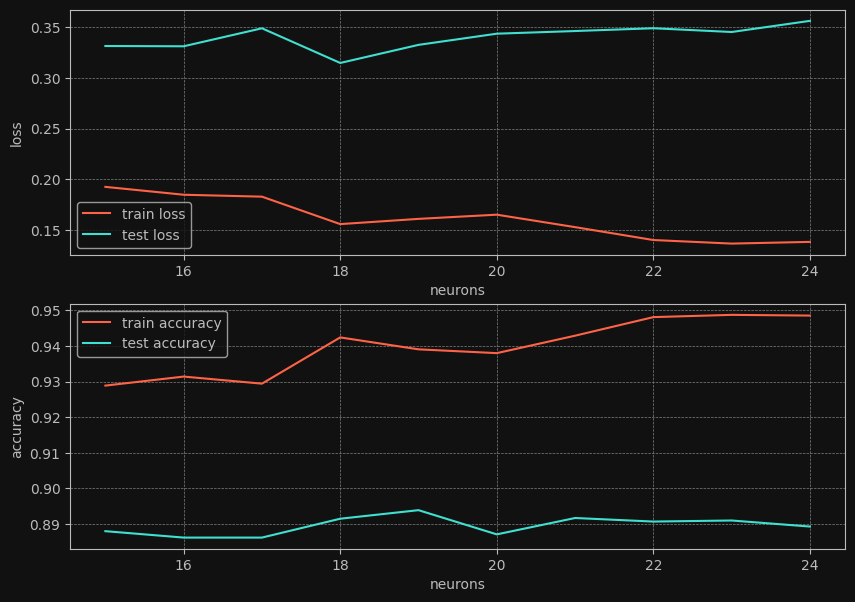

In [230]:
plt.figure(figsize=(10, 7))
epochs = [i for i in range(15, 25)]

plt.subplot(2, 1, 1)
plt.plot(epochs, np.array(evaluation['train'])[:, 0], c='tomato', label="train loss")
plt.plot(epochs, np.array(evaluation['test'])[:, 0], c='turquoise', label="test loss")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("neurons")
plt.ylabel("loss")
# plt.xticks(range(1, 11, 1))
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, np.array(evaluation['train'])[:, 1], c='tomato', label="train accuracy")
plt.plot(epochs, np.array(evaluation['test'])[:, 1], c='turquoise', label="test accuracy")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("neurons")
plt.ylabel("accuracy")
# plt.xticks(range(1, 11, 1))
plt.legend()

plt.show()

#### Result:
best model:
epochs:	19
Train Loss:	0.161	Train Accuracy:	0.939
Test Loss:	0.332	Test Accuracy:	0.894

old result (epochs 20):
Train Loss: 0.151 Train Accuracy: 0.945
Test Loss: 0.331 Test Accuracy: 0.899

new result (epochs 20):
epochs:	20
Train Loss:	0.165	Train Accuracy:	0.938
Test Loss:	0.344	Test Accuracy:	0.887

Хотя предыдущий результат был немного лучше, выберу итог из новых результатов с меньшим test loss и максимальным Accuracy.
 epochs: 19

#### Save model & optimizers

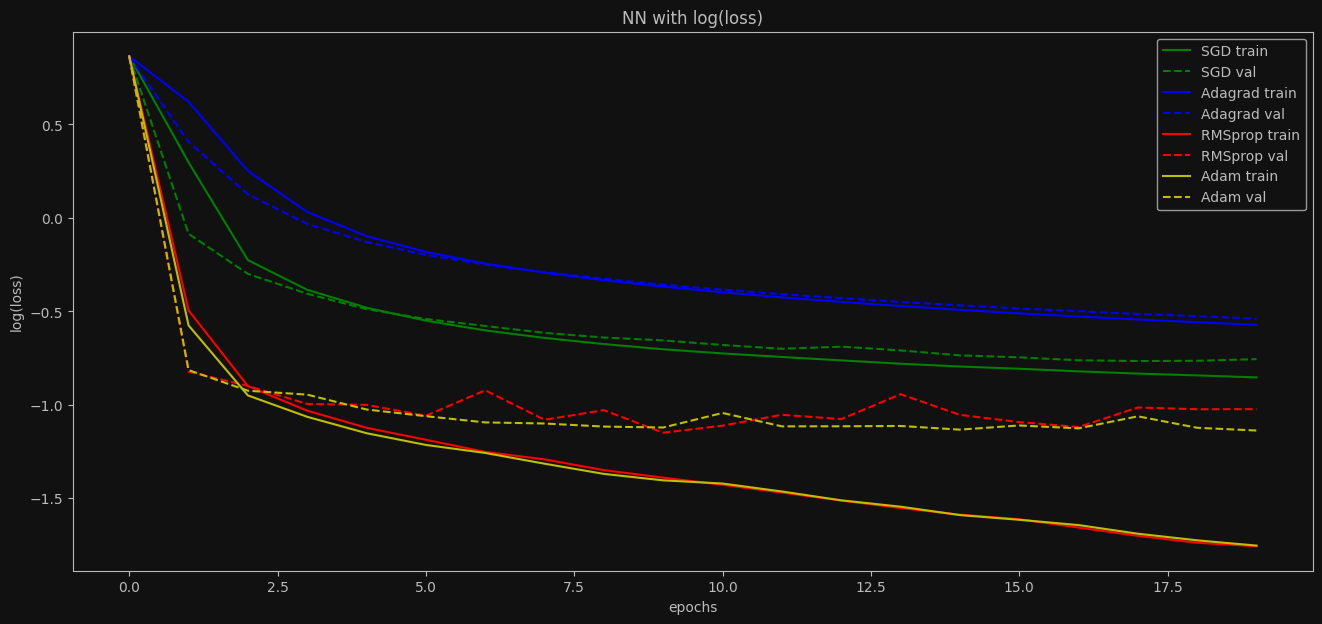

CPU times: total: 1min 12s
Wall time: 1min 1s


In [10]:
%%time

models = {}

plt.figure(figsize=(16, 7))
colors = ['g', 'b', 'r', 'y']

num_epochs = 19
batch_size=250
epoch = np.arange(num_epochs+1)

# Skeleton
model = Sequential([
    Dense(200, input_shape=(layer_size_0,), activation='relu'),
    Dense(200, activation='relu'),
    Dense(10, activation='sigmoid')
])

# save weights
model.save_weights('./samples/model_weights.h5')

for i, i_optim in enumerate([optimizers.gradient_descent_v2.SGD(),
                             optimizers.adagrad_v2.Adagrad(),
                             optimizers.rmsprop_v2.RMSProp(),
                             optimizers.adam_v2.Adam()
                            ]):

    model_i = Sequential([
        Dense(200, activation='relu', input_shape=(28 * 28,)),
        Dense(200, activation='relu'),
        Dense(10, activation='sigmoid'),
    ])

    model_i.load_weights('./samples/model_weights.h5')

    model_i.compile(
        optimizer=i_optim,
        loss='categorical_crossentropy',
        metrics='accuracy'
    )

    h0_train  = model_i.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
    h0_val = model_i.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)

    h = model_i.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0
    )

    models[i_optim.get_config()['name']] = model_i

    plt.plot(epoch, np.log([h0_train[0]] + h.history['loss']), '-', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' train')

    plt.plot(epoch, np.log([h0_val[0]] + h.history['val_loss']), '--', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' val')

plt.legend()
plt.title('NN with log(loss)')
plt.xlabel('epochs')
plt.ylabel('log(loss)')
plt.show()

# choice -> adam

In [12]:
model_i = models['Adam']
model_i.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

1/1 [==============================] - 0s 85ms/step


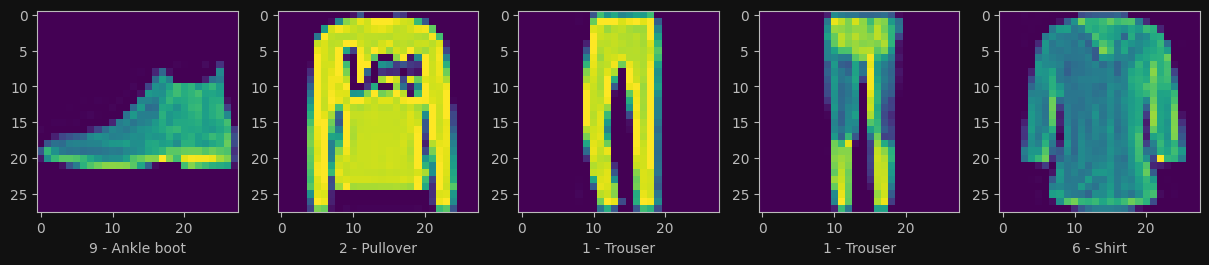

In [13]:
N = 5
y_pred = model_i.predict(X_test[:N, :])
y_pred_class = np.argmax(y_pred, axis=1)
plt.figure(figsize=(3 * N, 5))

for i in range(N):
  plt.subplot(1, N, i+1)
  plt.imshow(X_test[i,:].reshape(28, 28))
  plt.xlabel(f'{y_test_labels[i]} - {dict_things[y_test_labels[i]]}')
plt.show()

In [17]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

313/313 [==============================] - 0s 1ms/step
Confusion matrix, without normalization


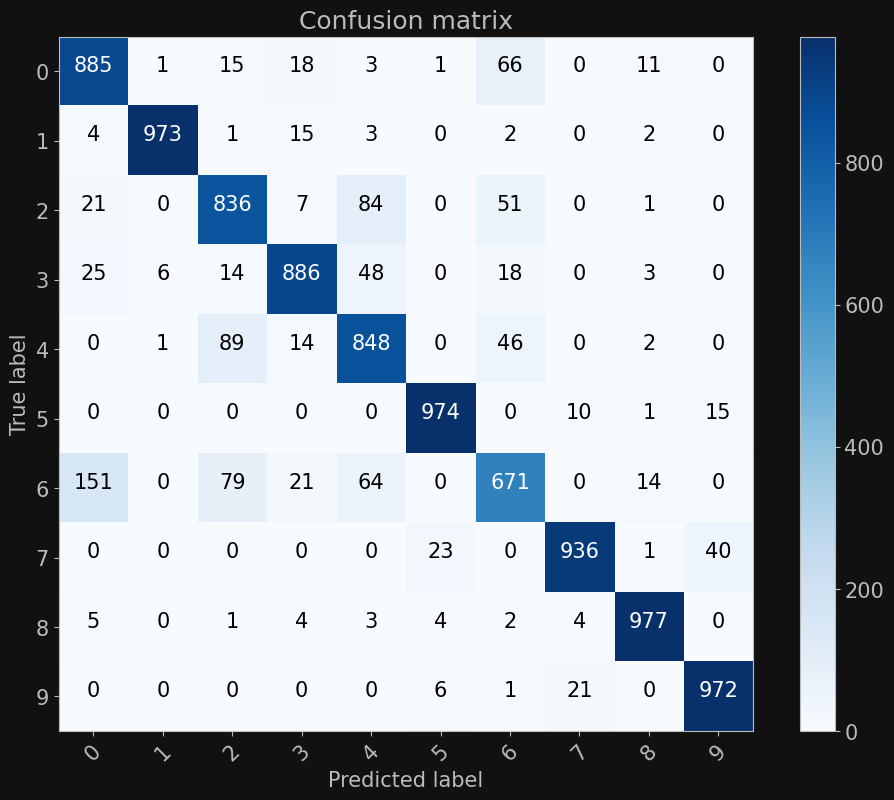

In [19]:
from sklearn.metrics import confusion_matrix

y_pred = model_i.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_labels, y_pred_class)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                      title='Confusion matrix', normalize=False)
plt.show()

Есть заметное количество неверных предсказаний: 0 - 6, 2 - 4, 2 - 6, 9 - 7

#### Conclusion:

Подбирая количество слоев, их размер, количество нейронов, размер batch, эпохи и подходящие оптимизаторы, мы можем значительно улучшить наш прогноз.

Стоит искать золотую середину между качеством модели и производительностью, но, конечно, все зависит от поставленной задачи.

Из особенностей:
* Количество слоев напрямую влияет на сложность настройки модели. Чем их больше, тем сложнее подобрать нужные параметры.
* Достаточное количество нейронов положительно влияет на качество модели, но есть риск переобучения или лишней нагрузки
на CPU/GPU (если, например, много эпох и маленький batch_size).
* Размер каждого слоя влияет на поведение следующего.

Из функций я использовал keras.backend.set_session, keras.backend.clear_session, keras.backend.get_session, gc.collect
для создания функции keras_reset. Не буду лукавить, решение подсмотрел в интернете.
Дело в том, что при обработке большого количества итераций память видеокарты заполнялась, но не происходило срабатывания garbage при завершении итерации, хотя по идее это должно происходить в автоматическом режиме. Из-за заполнения памяти вылетала ошибка. И приходилось перезапускать ядро Jupyter.

Функция keras_reset принудительно завершает сессию, очищает память и создает новую сессию. Подставляя эту функцию в цикл, мы добиваемся того, что используемая память обнуляется при начале каждого прохода.